In [1]:
# Load modules

import xarray as xr
import pandas as pd
import numpy as np
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import zarr
import gcsfs
import xesmf as xe
from scipy.interpolate import griddata
from xmip.preprocessing import rename_cmip6
from matplotlib import gridspec

In [3]:
tas = xr.open_dataarray('/data/keeling/a/mailes2/a/processed_var_data/250yeardatasets/CMIP_tas_35model_piControl_2x2_250yr.nc')
tas.load()

<xarray.DataArray 'tas' (name: 35, time: 3000, lat: 88, lon: 179)>
array([[[[240.40133209, 240.23360519, 240.07335281, ..., 241.07644882,
          240.9070549 , 240.73804626],
         [241.85151443, 241.50689392, 241.3044548 , ..., 243.4271637 ,
          243.04072571, 242.65569763],
         [245.13447876, 244.64059372, 244.16197968, ..., 247.53827667,
          246.92674637, 246.31152954],
         ...,
         [242.47323227, 242.79238129, 243.11200333, ..., 240.83494263,
          241.18084335, 241.53199844],
         [239.27754059, 239.47279968, 239.67601395, ..., 238.49070511,
          238.6950264 , 238.89722214],
         [236.1229126 , 236.16923904, 236.22423935, ..., 235.93309021,
          235.9812088 , 236.02891464]],

        [[232.33238297, 232.10248413, 231.87952423, ..., 233.2583847 ,
          233.02594376, 232.79409714],
         [233.18961639, 232.75522842, 232.4497757 , ..., 235.1334259 ,
          234.64775085, 234.16322174],
         [235.71060333, 235.12069931, 234.54930115, ..., 238.61993561,
          237.92444611, 237.22615433],
...
         [246.19675025, 246.31586663, 246.34271079, ..., 245.48980816,
          245.75051176, 245.9245243 ],
         [244.19683736, 244.18944524, 244.18038856, ..., 244.05989566,
          244.10119587, 244.13069517],
         [243.04682709, 243.07683151, 243.10206223, ..., 243.00653488,
          243.00411758, 243.00201136]],

        [[242.0207427 , 242.06181763, 242.0120374 , ..., 242.78211273,
          242.46943156, 242.46186747],
         [242.99428482, 242.66003062, 242.39183468, ..., 244.15340347,
          243.87034607, 243.36576428],
         [245.36263562, 245.15486799, 244.67690006, ..., 246.6449792 ,
          246.44899351, 246.16430815],
         ...,
         [240.33191359, 240.32348636, 240.26558439, ..., 240.10385332,
          240.15077125, 240.24199812],
         [239.9957205 , 239.93989987, 239.9025951 , ..., 240.14502369,
          240.11653307, 240.09446733],
         [239.23406321, 239.23479126, 239.23009389, ..., 239.36224345,
          239.31313426, 239.25672414]]]])
Coordinates:
    height   float64 2.0
  * time     (time) datetime64[ns] 1851-01-31 1851-02-28 ... 2100-12-31
  * lat      (lat) int64 -87 -85 -83 -81 -79 -77 -75 ... 75 77 79 81 83 85 87
  * lon      (lon) int64 1 3 5 7 9 11 13 15 ... 343 345 347 349 351 353 355 357
  * name     (name) object 'GFDL-CM4' 'GFDL-ESM4' ... 'TaiESM1'
Attributes:
    cell_measures:  area: areacella
    cell_methods:   area: time: mean
    interp_method:  conserve_order2
    long_name:      Near-Surface Air Temperature
    original_name:  tas
    standard_name:  air_temperature
    units:          K

# Load humidity

In [2]:
# Head to google catalog to get some vertical motion data

# Read in data catalog

df = pd.read_csv('https://storage.googleapis.com/cmip6/cmip6-zarr-consolidated-stores.csv')
df.head()

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
0,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,ps,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706
1,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,rsds,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706
2,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,rlus,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706
3,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,rlds,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706
4,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,psl,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706


In [3]:
df_prw = df.query("activity_id=='CMIP' & table_id=='Amon' & variable_id=='prw' & experiment_id=='piControl' & member_id=='r1i1p1f1'")
df_prw = df_prw.drop_duplicates('source_id')
df_prw = df_prw[~df_prw['source_id'].isin(['MCM-UA-1-0','GISS-E2-1-G-CC','NorESM1-F','IITM-ESM',
                                            'GISS-E2-2-G','AWI-ESM-1-1-LR','EC-Earth3-LR',
                                            'E3SM-1-1-ECA','MIROC-ES2H','ICON-ESM-LR',
                                            'KIOST-ESM','GISS-E2-1-H','EC-Earth3-Veg',
                                           'MPI-ESM-1-2-HAM','HadGEM3-GC31-LL','NESM3','E3SM-1-1','ACCESS-ESM1-5'])]
#print(len(df_prw))
#df_prw = df_prw.drop(index=[66843,72923,208934,213488,217618,242540,254017,289244,294905,376617,384391,395392,395671])
print(len(df_prw))
df_prw

33


,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
9378,CMIP,NOAA-GFDL,GFDL-CM4,piControl,r1i1p1f1,Amon,prw,gr1,gs://cmip6/CMIP6/CMIP/NOAA-GFDL/GFDL-CM4/piCon...,NaN,20180701
18478,CMIP,NOAA-GFDL,GFDL-ESM4,piControl,r1i1p1f1,Amon,prw,gr1,gs://cmip6/CMIP6/CMIP/NOAA-GFDL/GFDL-ESM4/piCo...,NaN,20180701
32293,CMIP,NASA-GISS,GISS-E2-1-G,piControl,r1i1p1f1,Amon,prw,gn,gs://cmip6/CMIP6/CMIP/NASA-GISS/GISS-E2-1-G/pi...,NaN,20180824
40396,CMIP,BCC,BCC-CSM2-MR,piControl,r1i1p1f1,Amon,prw,gn,gs://cmip6/CMIP6/CMIP/BCC/BCC-CSM2-MR/piContro...,NaN,20181016
44841,CMIP,BCC,BCC-ESM1,piControl,r1i1p1f1,Amon,prw,gn,gs://cmip6/CMIP6/CMIP/BCC/BCC-ESM1/piControl/r...,NaN,20181214
55600,CMIP,MRI,MRI-ESM2-0,piControl,r1i1p1f1,Amon,prw,gn,gs://cmip6/CMIP6/CMIP/MRI/MRI-ESM2-0/piControl...,NaN,20190222
65236,CMIP,MIROC,MIROC6,piControl,r1i1p1f1,Amon,prw,gn,gs://cmip6/CMIP6/CMIP/MIROC/MIROC6/piControl/r...,NaN,20190311
67650,CMIP,NCAR,CESM2,piControl,r1i1p1f1,Amon,prw,gn,gs://cmip6/CMIP6/CMIP/NCAR/CESM2/piControl/r1i...,NaN,20190320
67699,CMIP,NCAR,CESM2-WACCM,piControl,r1i1p1f1,Amon,prw,gn,gs://cmip6/CMIP6/CMIP/NCAR/CESM2-WACCM/piContr...,NaN,20190320
89841,CMIP,CCCma,CanESM5,piControl,r1i1p1f1,Amon,prw,gn,gs://cmip6/CMIP6/CMIP/CCCma/CanESM5/piControl/...,NaN,20190429


In [4]:
#this only needs to be created once
# From Ryan Abernathy's tutorial - Way 2
gcs = gcsfs.GCSFileSystem(token='anon')
fs = gcsfs.GCSFileSystem(token='anon', access='read_only')

# Regridding
new_lats=np.arange(-87,88,2)
new_lons=np.arange(1,359,2)

#time index to assign model times to
new_time_index=pd.date_range(start='1851-01-01',freq='M',periods=3000) #250 years
new_time_index
    
dset_list_prw = []
for zstore in df_prw.zstore.unique():
    # make a nice concise name from the zstore value
    name = zstore.split('gs://cmip6/CMIP6/')[1].replace('/','.')[:-1]
    name = zstore.split('gs://cmip6/CMIP6/CMIP/')[1].replace('/','.')[:-1]
    name_list = name.split('.')
    name = name_list[1]
    print(name)
    ds = xr.open_zarr(fs.get_mapper(zstore),consolidated=True)
    print(ds.time)
    ds_sel = ds.isel(time=slice(len(ds.time)-3000,len(ds.time)))
    print(ds_sel.time.head(1).values)
    print(ds_sel.time.tail(1).values)
    ds_prw_interp = ds_sel.assign(time=new_time_index).interp(lat=new_lats,lon=new_lons)
    ds_prw = ds_prw_interp.prw
    ds_prw['name'] = name # Creating a new dimension for each ensemble member
    dset_list_prw.append(ds_prw)

GFDL-CM4
<xarray.DataArray 'time' (time: 6000)>
array([cftime.DatetimeNoLeap(151, 1, 16, 12, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(151, 2, 15, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(151, 3, 16, 12, 0, 0, 0, has_year_zero=True), ...,
       cftime.DatetimeNoLeap(650, 10, 16, 12, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(650, 11, 16, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(650, 12, 16, 12, 0, 0, 0, has_year_zero=True)],
      dtype=object)
Coordinates:
  * time     (time) object 0151-01-16 12:00:00 ... 0650-12-16 12:00:00
Attributes:
    axis:           T
    bounds:         time_bnds
    calendar_type:  noleap
    description:    for time-mean fields
    long_name:      time
    standard_name:  time
[cftime.DatetimeNoLeap(401, 1, 16, 12, 0, 0, 0, has_year_zero=True)]
[cftime.DatetimeNoLeap(650, 12, 16, 12, 0, 0, 0, has_year_zero=True)]
GFDL-ESM4
<xarray.DataArray 'time' (time: 6000)>
array([cftime.Datetim

/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/coding/times.py:688: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/core/indexing.py:524: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)


<xarray.DataArray 'time' (time: 9600)>
array([cftime.DatetimeGregorian(3200, 1, 16, 12, 0, 0, 0, has_year_zero=False),
       cftime.DatetimeGregorian(3200, 2, 15, 12, 0, 0, 0, has_year_zero=False),
       cftime.DatetimeGregorian(3200, 3, 16, 12, 0, 0, 0, has_year_zero=False),
       ...,
       cftime.DatetimeGregorian(3999, 10, 16, 12, 0, 0, 0, has_year_zero=False),
       cftime.DatetimeGregorian(3999, 11, 16, 0, 0, 0, 0, has_year_zero=False),
       cftime.DatetimeGregorian(3999, 12, 16, 12, 0, 0, 0, has_year_zero=False)],
      dtype=object)
Coordinates:
  * time     (time) object 3200-01-16 12:00:00 ... 3999-12-16 12:00:00
Attributes:
    axis:           T
    bounds:         time_bnds
    long_name:      time
    standard_name:  time
[cftime.DatetimeGregorian(3750, 1, 16, 12, 0, 0, 0, has_year_zero=False)]
[cftime.DatetimeGregorian(3999, 12, 16, 12, 0, 0, 0, has_year_zero=False)]
CESM2
<xarray.DataArray 'time' (time: 14400)>
array([cftime.DatetimeNoLeap(1, 1, 15, 12, 0, 0, 0, h

/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/coding/times.py:688: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/coding/times.py:688: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/core/indexing.py:524: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dty

<xarray.DataArray 'time' (time: 12000)>
array([cftime.DatetimeProlepticGregorian(1850, 1, 16, 12, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeProlepticGregorian(1850, 2, 15, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeProlepticGregorian(1850, 3, 16, 12, 0, 0, 0, has_year_zero=True),
       ...,
       cftime.DatetimeProlepticGregorian(2849, 10, 16, 12, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeProlepticGregorian(2849, 11, 16, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeProlepticGregorian(2849, 12, 16, 12, 0, 0, 0, has_year_zero=True)],
      dtype=object)
Coordinates:
  * time     (time) object 1850-01-16 12:00:00 ... 2849-12-16 12:00:00
Attributes:
    axis:           T
    bounds:         time_bnds
    long_name:      time
    standard_name:  time
[cftime.DatetimeProlepticGregorian(2600, 1, 16, 12, 0, 0, 0, has_year_zero=True)]
[cftime.DatetimeProlepticGregorian(2849, 12, 16, 12, 0, 0, 0, has_year_zero=True)]
MPI-ESM1-2-HR


/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/core/indexing.py:524: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)
/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/coding/times.py:688: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/coding/times.py:688: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use

<xarray.DataArray 'time' (time: 6000)>
array([cftime.DatetimeProlepticGregorian(1850, 1, 16, 12, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeProlepticGregorian(1850, 2, 15, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeProlepticGregorian(1850, 3, 16, 12, 0, 0, 0, has_year_zero=True),
       ...,
       cftime.DatetimeProlepticGregorian(2349, 10, 16, 12, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeProlepticGregorian(2349, 11, 16, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeProlepticGregorian(2349, 12, 16, 12, 0, 0, 0, has_year_zero=True)],
      dtype=object)
Coordinates:
  * time     (time) object 1850-01-16 12:00:00 ... 2349-12-16 12:00:00
Attributes:
    axis:           T
    bounds:         time_bnds
    long_name:      time
    standard_name:  time
[cftime.DatetimeProlepticGregorian(2100, 1, 16, 12, 0, 0, 0, has_year_zero=True)]
[cftime.DatetimeProlepticGregorian(2349, 12, 16, 12, 0, 0, 0, has_year_zero=True)]
EC-Earth3


/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/core/indexing.py:524: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)


<xarray.DataArray 'time' (time: 6012)>
array([cftime.DatetimeProlepticGregorian(2259, 1, 16, 12, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeProlepticGregorian(2259, 2, 15, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeProlepticGregorian(2259, 3, 16, 12, 0, 0, 0, has_year_zero=True),
       ...,
       cftime.DatetimeProlepticGregorian(2759, 10, 16, 12, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeProlepticGregorian(2759, 11, 16, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeProlepticGregorian(2759, 12, 16, 12, 0, 0, 0, has_year_zero=True)],
      dtype=object)
Coordinates:
  * time     (time) object 2259-01-16 12:00:00 ... 2759-12-16 12:00:00
Attributes:
    axis:           T
    bounds:         time_bnds
    long_name:      time
    standard_name:  time
[cftime.DatetimeProlepticGregorian(2510, 1, 16, 12, 0, 0, 0, has_year_zero=True)]
[cftime.DatetimeProlepticGregorian(2759, 12, 16, 12, 0, 0, 0, has_year_zero=True)]
E3SM-1-0
<xarray.DataArray 'time' (t

/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/coding/times.py:688: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/coding/times.py:688: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/core/indexing.py:524: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dty

<xarray.DataArray 'time' (time: 6000)>
array([cftime.DatetimeProlepticGregorian(2401, 1, 16, 12, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeProlepticGregorian(2401, 2, 15, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeProlepticGregorian(2401, 3, 16, 12, 0, 0, 0, has_year_zero=True),
       ...,
       cftime.DatetimeProlepticGregorian(2900, 10, 16, 12, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeProlepticGregorian(2900, 11, 16, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeProlepticGregorian(2900, 12, 16, 12, 0, 0, 0, has_year_zero=True)],
      dtype=object)
Coordinates:
  * time     (time) object 2401-01-16 12:00:00 ... 2900-12-16 12:00:00
Attributes:
    axis:           T
    bounds:         time_bnds
    long_name:      time
    standard_name:  time
[cftime.DatetimeProlepticGregorian(2651, 1, 16, 12, 0, 0, 0, has_year_zero=True)]
[cftime.DatetimeProlepticGregorian(2900, 12, 16, 12, 0, 0, 0, has_year_zero=True)]
NorESM2-MM
<xarray.DataArray 'time' 

/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/coding/times.py:688: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/coding/times.py:150: SerializationWarning: Ambiguous reference date string: 950-01-01. The first value is assumed to be the year hence will be padded with zeros to remove the ambiguity (the padded reference date string is: 0950-01-01). To remove this message, remove the ambiguity by padding your reference date strings with zeros.
  warnings.warn(warning_msg, SerializationWarning)
/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/core/indexing.py:524: SerializationWarning: Unable to decode time axis into full numpy.datetime64 ob

<xarray.DataArray 'time' (time: 6000)>
array([cftime.DatetimeProlepticGregorian(950, 1, 16, 12, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeProlepticGregorian(950, 2, 15, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeProlepticGregorian(950, 3, 16, 12, 0, 0, 0, has_year_zero=True),
       ...,
       cftime.DatetimeProlepticGregorian(1449, 10, 16, 12, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeProlepticGregorian(1449, 11, 16, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeProlepticGregorian(1449, 12, 16, 12, 0, 0, 0, has_year_zero=True)],
      dtype=object)
Coordinates:
  * time     (time) object 0950-01-16 12:00:00 ... 1449-12-16 12:00:00
Attributes:
    axis:           T
    bounds:         time_bnds
    long_name:      time
    standard_name:  time
[cftime.DatetimeProlepticGregorian(1200, 1, 16, 12, 0, 0, 0, has_year_zero=True)]
[cftime.DatetimeProlepticGregorian(1449, 12, 16, 12, 0, 0, 0, has_year_zero=True)]
CESM2-WACCM-FV2
<xarray.DataArray 'time

/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/coding/times.py:688: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/core/indexing.py:524: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)


<xarray.DataArray 'time' (time: 6012)>
array([cftime.DatetimeProlepticGregorian(2300, 1, 16, 12, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeProlepticGregorian(2300, 2, 15, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeProlepticGregorian(2300, 3, 16, 12, 0, 0, 0, has_year_zero=True),
       ...,
       cftime.DatetimeProlepticGregorian(2800, 10, 16, 12, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeProlepticGregorian(2800, 11, 16, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeProlepticGregorian(2800, 12, 16, 12, 0, 0, 0, has_year_zero=True)],
      dtype=object)
Coordinates:
  * time     (time) object 2300-01-16 12:00:00 ... 2800-12-16 12:00:00
Attributes:
    axis:           T
    bounds:         time_bnds
    long_name:      time
    standard_name:  time
[cftime.DatetimeProlepticGregorian(2551, 1, 16, 12, 0, 0, 0, has_year_zero=True)]
[cftime.DatetimeProlepticGregorian(2800, 12, 16, 12, 0, 0, 0, has_year_zero=True)]
KACE-1-0-G
<xarray.DataArray 'time' 

/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/coding/times.py:688: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/core/indexing.py:524: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)


<xarray.DataArray 'time' (time: 14400)>
array([cftime.DatetimeGregorian(1850, 1, 16, 12, 0, 0, 0, has_year_zero=False),
       cftime.DatetimeGregorian(1850, 2, 15, 0, 0, 0, 0, has_year_zero=False),
       cftime.DatetimeGregorian(1850, 3, 16, 12, 0, 0, 0, has_year_zero=False),
       ...,
       cftime.DatetimeGregorian(3049, 10, 16, 12, 0, 0, 0, has_year_zero=False),
       cftime.DatetimeGregorian(3049, 11, 16, 0, 0, 0, 0, has_year_zero=False),
       cftime.DatetimeGregorian(3049, 12, 16, 12, 0, 0, 0, has_year_zero=False)],
      dtype=object)
Coordinates:
  * time     (time) object 1850-01-16 12:00:00 ... 3049-12-16 12:00:00
Attributes:
    axis:           T
    bounds:         time_bounds
    long_name:      Time axis
    standard_name:  time
[cftime.DatetimeGregorian(2800, 1, 16, 12, 0, 0, 0, has_year_zero=False)]
[cftime.DatetimeGregorian(3049, 12, 16, 12, 0, 0, 0, has_year_zero=False)]
CIESM
<xarray.DataArray 'time' (time: 6000)>
array([cftime.DatetimeNoLeap(1, 1, 16, 12, 0, 0

In [5]:
prw_control = xr.concat(dset_list_prw, dim='name', coords='minimal', compat='override')
prw_control.load()

<xarray.DataArray 'prw' (name: 33, time: 3000, lat: 88, lon: 179)>
array([[[[8.61285070e-01, 8.51347461e-01, 8.41626227e-01, ...,
          9.01039162e-01, 8.91100094e-01, 8.81161380e-01],
         [9.08883485e-01, 9.08446175e-01, 9.03694302e-01, ...,
          9.71516529e-01, 9.53838497e-01, 9.36211520e-01],
         [1.13235131e+00, 1.10285771e+00, 1.07568714e+00, ...,
          1.26194803e+00, 1.22234270e+00, 1.18328298e+00],
         ...,
         [1.77952811e+00, 1.78530525e+00, 1.79040217e+00, ...,
          1.74137356e+00, 1.74963295e+00, 1.75805983e+00],
         [1.59713157e+00, 1.59505341e+00, 1.58994442e+00, ...,
          1.60403616e+00, 1.60225731e+00, 1.60037897e+00],
         [1.40390548e+00, 1.39979827e+00, 1.39555919e+00, ...,
          1.42022554e+00, 1.41616163e+00, 1.41208756e+00]],

        [[5.06567030e-01, 5.00136870e-01, 4.93890338e-01, ...,
          5.32487664e-01, 5.25978461e-01, 5.19487461e-01],
         [5.66102120e-01, 5.63618293e-01, 5.58923125e-01, ...,
          6.12460330e-01, 5.99837765e-01, 5.87245849e-01],
         [7.00892717e-01, 6.81514281e-01, 6.63119018e-01, ...,
          7.80077270e-01, 7.54108846e-01, 7.28847867e-01],
...
         [1.65805864e-02, 1.72873794e-02, 1.72204703e-02, ...,
          1.36160402e-02, 1.40147456e-02, 1.48149014e-02],
         [1.06287025e-02, 1.12119095e-02, 1.13020901e-02, ...,
          7.97657188e-03, 8.61658746e-03, 9.33726330e-03],
         [7.30140299e-03, 7.31204994e-03, 7.42971426e-03, ...,
          7.31359480e-03, 7.28210101e-03, 7.32688033e-03]],

        [[1.23071958e-02, 1.24628261e-02, 1.15306012e-02, ...,
          1.51282085e-02, 1.34669413e-02, 1.08510564e-02],
         [1.51741248e-02, 1.31907206e-02, 1.18854938e-02, ...,
          2.06123932e-02, 1.91864327e-02, 1.76360668e-02],
         [1.51208472e-02, 1.48917060e-02, 1.52082780e-02, ...,
          1.61531253e-02, 1.47622607e-02, 1.45982684e-02],
         ...,
         [1.97223326e-02, 1.97176657e-02, 1.92564097e-02, ...,
          1.55858236e-02, 1.69417546e-02, 1.78326784e-02],
         [1.25793537e-02, 1.26558447e-02, 1.26573404e-02, ...,
          1.19815017e-02, 1.27288199e-02, 1.27181996e-02],
         [9.27570840e-03, 9.22701083e-03, 8.91791053e-03, ...,
          8.94712687e-03, 9.35611965e-03, 9.31509128e-03]]]])
Coordinates:
  * time     (time) datetime64[ns] 1851-01-31 1851-02-28 ... 2100-12-31
  * lat      (lat) int64 -87 -85 -83 -81 -79 -77 -75 ... 75 77 79 81 83 85 87
  * lon      (lon) int64 1 3 5 7 9 11 13 15 ... 343 345 347 349 351 353 355 357
  * name     (name) <U16 'GFDL-CM4' 'GFDL-ESM4' ... 'CIESM' 'CMCC-CM2-SR5'
Attributes:
    cell_measures:  area: areacella
    cell_methods:   area: time: mean
    interp_method:  conserve_order2
    long_name:      Water Vapor Path
    original_name:  prw
    standard_name:  atmosphere_mass_content_of_water_vapor
    units:          kg m-2

In [6]:
prw_control.to_netcdf('/data/keeling/a/mailes2/a/processed_var_data/250yeardatasets/CMIP_prw_33model_piControl_2x2_last250.nc')

In [24]:
prw_control.to_netcdf('/data/keeling/a/mailes2/a/processed_var_data/250yeardatasets/CMIP_prw_33model_piControl_2x2_250yr.nc')

Text(0.5, 0.99, 'Mean Water Vapor Path')

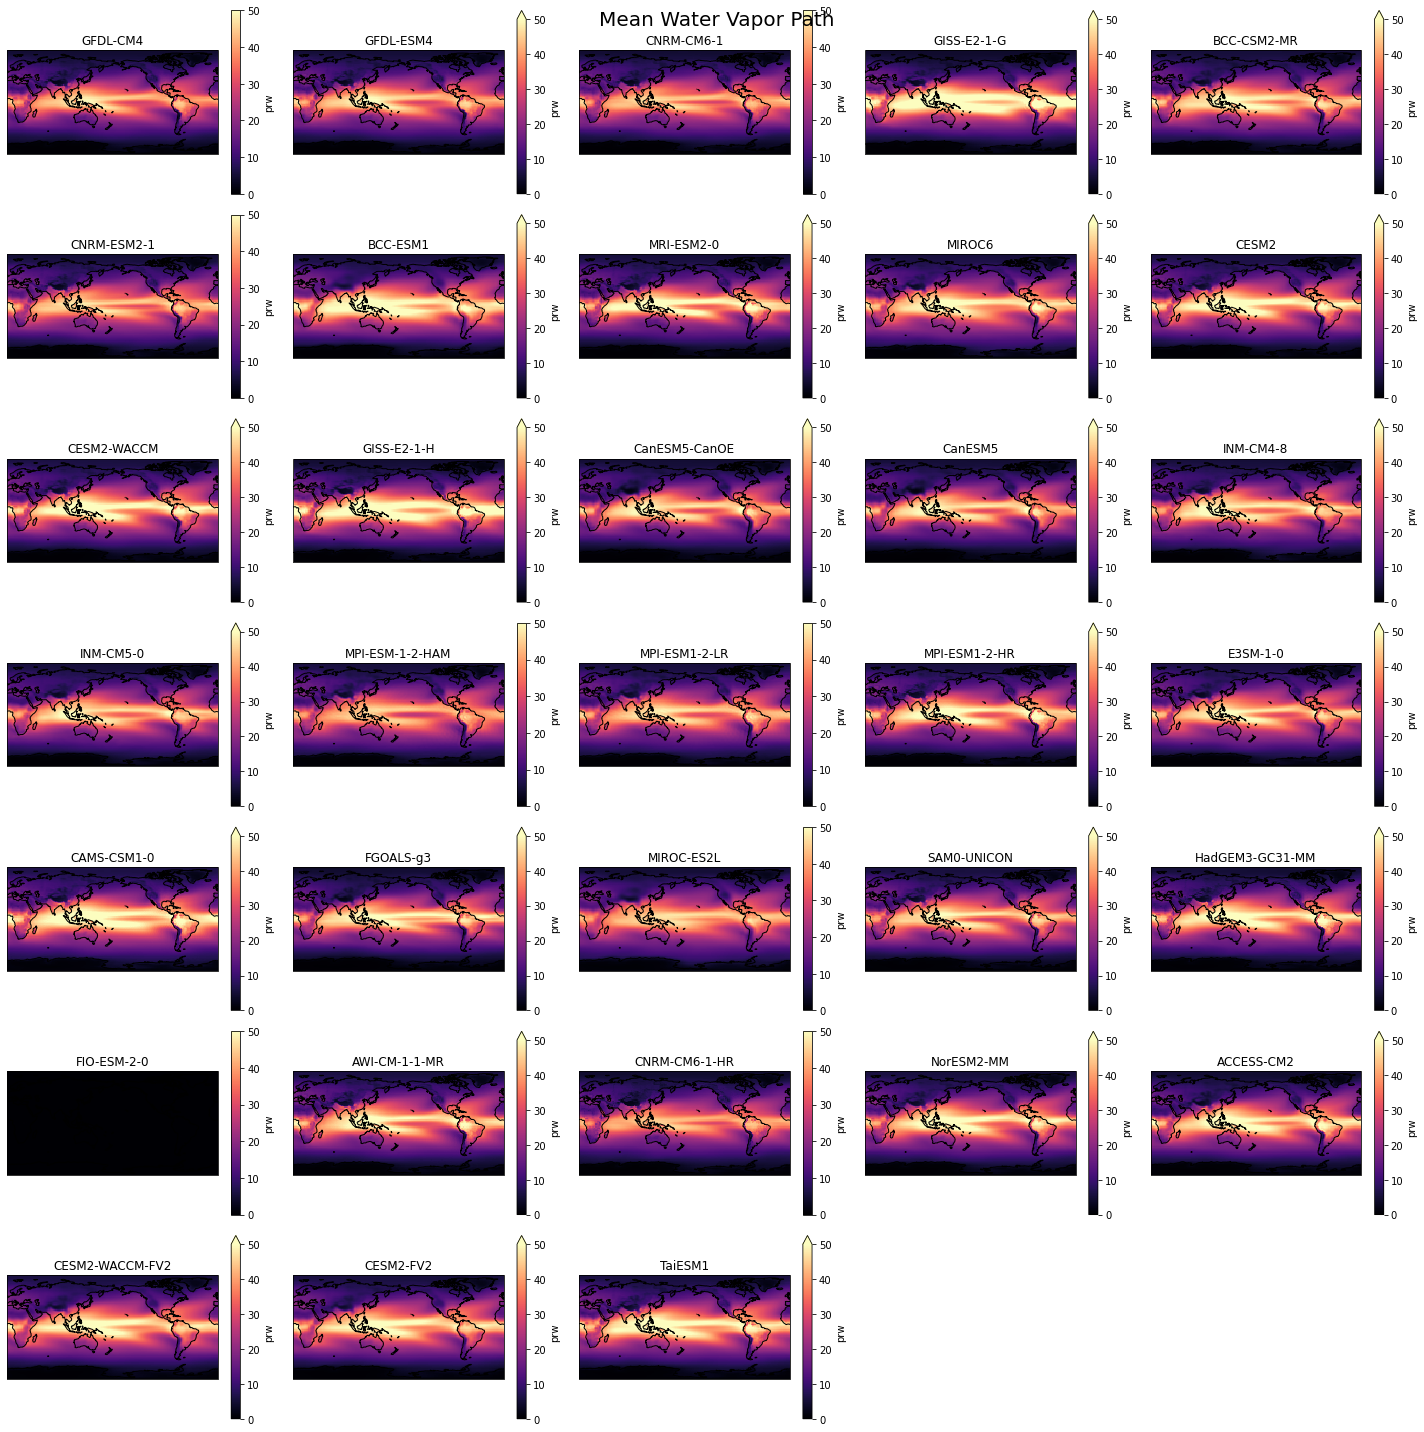

In [23]:
fig = plt.figure(figsize=(20,20))
gs = gridspec.GridSpec(1, 2)
gs.update(wspace=0.1)

i = 1

for model in prw_control['name'].values:
    ax = fig.add_subplot(7,5,i, projection=ccrs.PlateCarree(central_longitude=180))
    prw_control.sel(name=model).mean('time').plot(ax=ax, transform=ccrs.PlateCarree(), vmin=0, vmax=50, cmap='magma')
    ax.coastlines(color='black', linewidth=1)
    plt.title(model)
    i += 1
plt.tight_layout()
plt.suptitle('Mean Water Vapor Path', fontsize=20, y=0.99)

Text(0.5, 0.99, 'Mean Water Vapor Path')

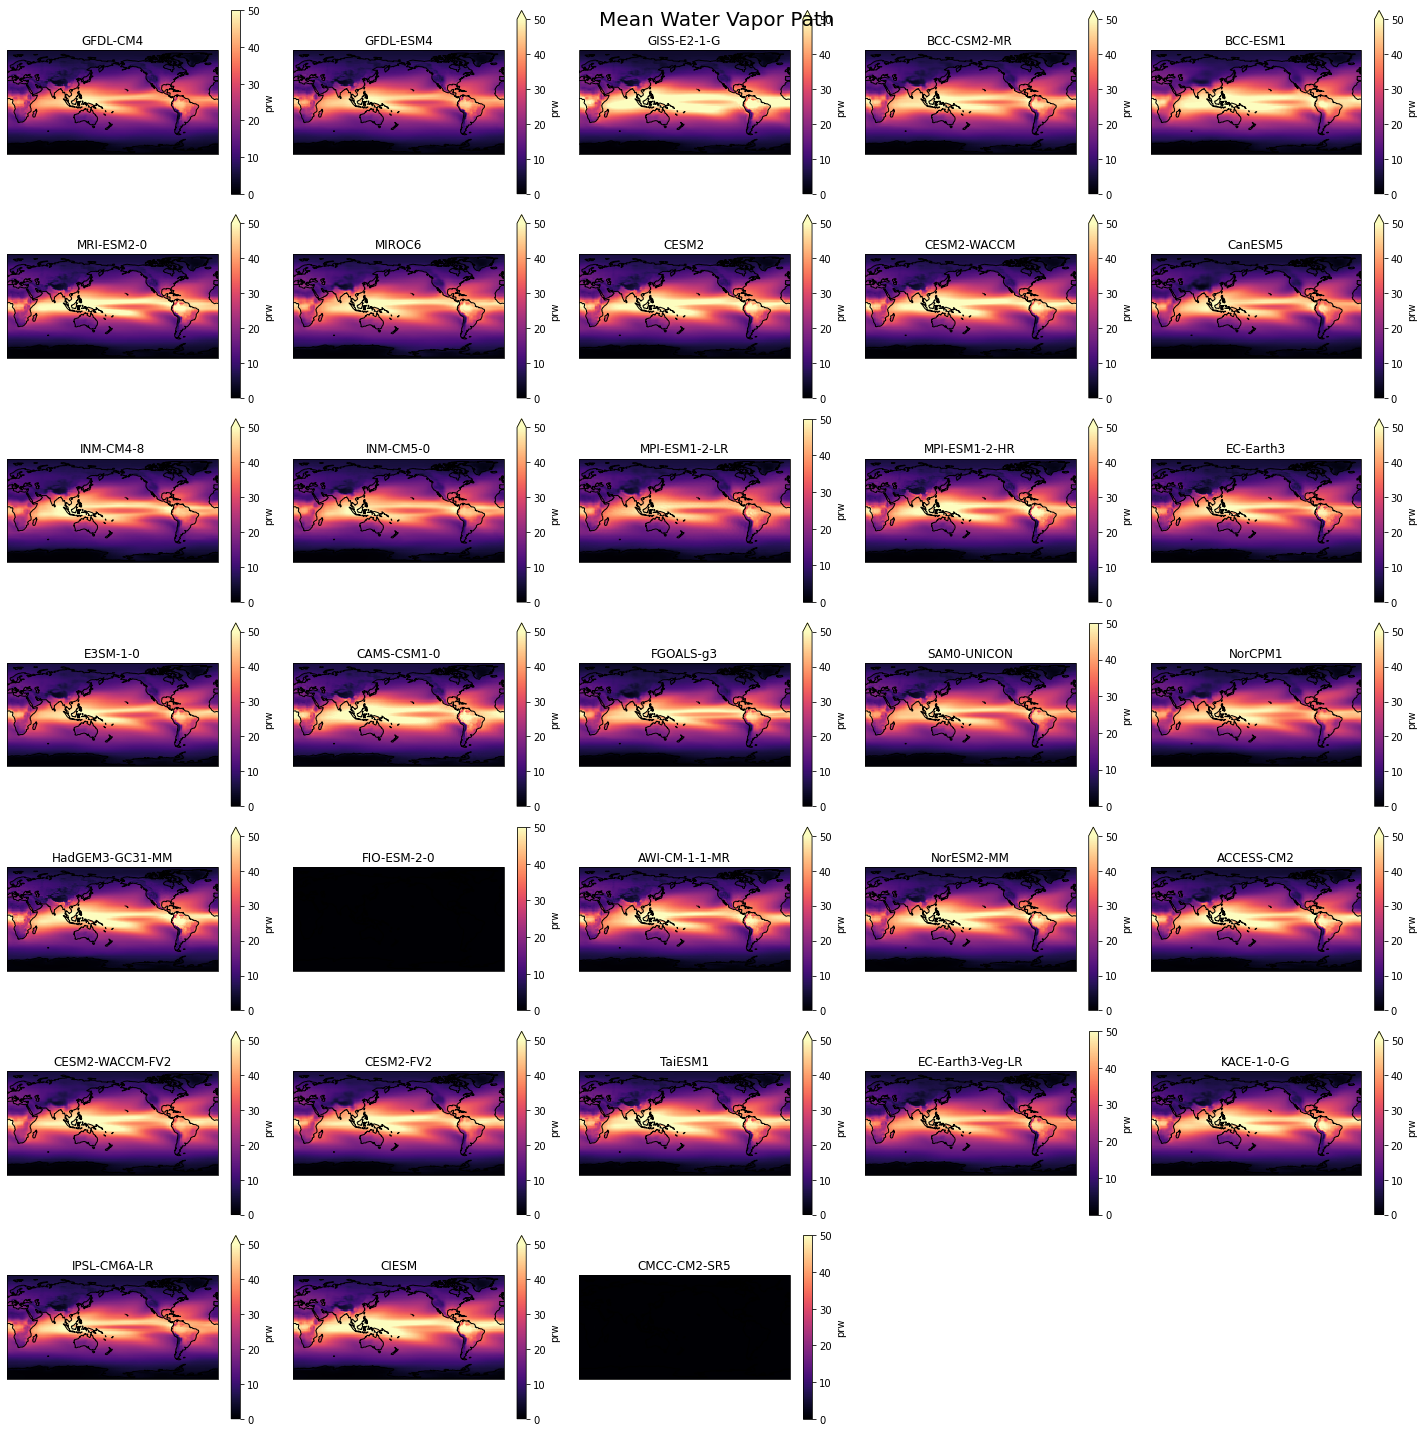

In [7]:
fig = plt.figure(figsize=(20,20))
gs = gridspec.GridSpec(1, 2)
gs.update(wspace=0.1)

i = 1

for model in prw_control['name'].values:
    ax = fig.add_subplot(7,5,i, projection=ccrs.PlateCarree(central_longitude=180))
    prw_control.sel(name=model).mean('time').plot(ax=ax, transform=ccrs.PlateCarree(), vmin=0, vmax=50, cmap='magma')
    ax.coastlines(color='black', linewidth=1)
    plt.title(model)
    i += 1
plt.tight_layout()
plt.suptitle('Mean Water Vapor Path', fontsize=20, y=0.99)